Let start by importing necessary package 

In [1]:
using Pkg
Pkg.activate(".")
using OptimalControl
using Plots
using ForwardDiff
using DifferentialEquations
using MINPACK
using Statistics

  Activating project at `c:\Users\uiv02757\OneDrive - Vitesco Technologies\git_repos\preconditioning`


We consider the following optimal control problem 
$$
    \left\{ \begin{array}{ll}
    \displaystyle \min_{x,u} \int_{0}^{t_f} x(t) ~\mathrm dt \\[1em]
    \text{s.c.}~\dot x(t) = u(t), & t\in [0, t_f]~\mathrm{a.e.}, \\[0.5em]
    \phantom{\mathrm{s.c.}~} u(t) \in [-1,1], & t\in [0, t_f], \\[0.5em]
    \phantom{\mathrm{s.c.}~} x(t_0) = 0, \quad x(t_f) = x_f,
    \end{array} \right.
$$

with $x_0 = 0$ and $t_f = 5$. The augmented pseudo-Hamiltonian of this problem is given by 

$$ 
    h(\tilde x, \tilde p,u) = p^0 u + p_1 x_1
$$ 
where $\tilde x = (x^0, x)$ is the augmented state, composed by the cost $x^0$ and the state $x$, and where $\tilde p = (p^0, p)$ is composed by the multiplier associated to the cost $p^0$ and the costate $p$. The maximizing control, which satisfy the maximization condition, is given by $u \to \mathrm{sign}(p)$. The true Hamiltonian is then given by 

$$
    H(\tilde x, \tilde p) = p^0 x + \lvert p \rvert. 
$$  


┌ Info: Saved animation to C:\Users\uiv02757\AppData\Local\Temp\jl_OjGHsBOdKn.gif
└ @ Plots C:\Users\uiv02757\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\uiv02757\\AppData\\Local\\Temp\\jl_OjGHsBOdKn.gif")
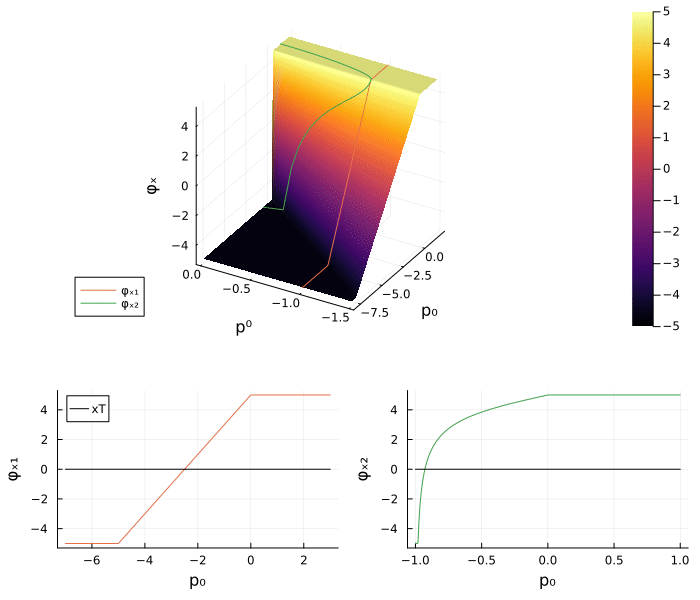

In [12]:
global α = 1

function condition(z, t, integrator)                        # event when condition(z,t,integrator) == 0
    x⁰,x,p⁰,p = z
    return p
end
function affect!(integrator)                                # action when condition == 0 
    global α = -α
    nothing
end

cb = ContinuousCallback(condition, affect!)                 # callback 
H(x, p) = p[1] * x[2] + α * p[2]
ϕ_ = Flow(Hamiltonian(H), callback = cb)                     # flow with maximizing control 

function ϕ(t0, x0, p0, tf; kwargs...)  
    if p0[2] == 0
        global α = -sign(p0[1])
    else
        global α = sign(p0[2])
    end
    return ϕ_(t0, x0, p0, tf; kwargs...)
end

function ϕ((t0, tf), x0, p0; kwargs...)                     # flow for plot
    if p0[2] == 0
        global α = -sign(p0[1])
    else
        global α = sign(p0[2])
    end
    return ϕ_((t0, tf), x0, p0; kwargs...)
end

t0 = 0; x0 = [0,0]; tf = 5; xT = 0;                         # final condition

π((x,p)) = x[2];                                            # projection on state space

ϕₓ(p0) = π( ϕ(t0, x0, p0, tf) )
η(p0) = -sqrt.(1 - p0.^2)
ϕₓ₁(p0) = ϕₓ([-1, p0])
ϕₓ₂(p0) = abs(p0) < 1 ? ϕₓ([η(p0), p0]) : sign(p0)*tf

# Plot
plt_S1 = plot(range(-7, 3, 500), ϕₓ₁ , color = 2, label = "")
plot!([-7,3], [xT,xT], color = :black, label = "xT")
plot!(xlabel = "p₀", ylabel = "φₓ₁")

plt_S2 = plot(range(-1, 1, 500), ϕₓ₂, color = 3)
plot!([-1,1], [xT,xT], color = :black)
plot!(xlabel = "p₀", ylabel = "φₓ₂", legend=false)

ϕₓ_(p⁰, p) = ϕₓ([p⁰, p])
plt_S = surface(range(0, -1.5, 100), range(-8, 2, 100), ϕₓ_, camera = (30,30))
surface!(xlabel = "p⁰", ylabel = "p₀", zlabel = "φₓ", xflip = true)
plot3d!(-1*ones(100), range(-8, 2, 100), ϕₓ₁.(range(-8, 2, 100)), label = "φₓ₁")
plot3d!(η.(range(-1, 1, 100)), range(-1, 1, 100), ϕₓ₂.(range(-1, 1, 100)), label = "φₓ₂")

plt_S12 = plot(plt_S1, plt_S2, layout = (1,2))
plt_total = plot(plt_S, plt_S12, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

@gif for i ∈ [range(30, 90, 50); 90*ones(25); range(90, 30, 50); 30*ones(25)]
    plot!(plt_total[1], camera=(i,i), 
        zticks = i==90 ? false : true,
        zlabel = i==90 ? "" : "φₓ" )
end

Evaluation on ξ : 3.8452994616207485
Jacobian on ξ : 3.0792014356780086
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.845299e+00     0.000000e+00         0.144000
     2     5.000000e+00     1.559496e+00         0.288000
     3     5.000000e+00     4.983094e-01         0.000000
     4     5.000000e+00     4.983094e-01         0.000000
     5     5.000000e+00     4.983094e-01         0.000000
     6     2.825589e+00     9.417471e-02         0.002000
     7     3.275582e+00     5.569993e-02         0.000000
     8     1.835694e+00     1.605481e-02         0.001000
     9     5.000000e+00     4.108358e-02         0.000000
    10     8.767661e-01     2.198078e-02         0.000000
    11     1.052824e+00     2.476848e-03         0.000000
    12     2.252319e-01     7.373618e-04         0.001000
    13     6.733089e-02     6.111140e-05         0.001000
    14     4.061534e-03     3.236777e-06         0.000000
    1

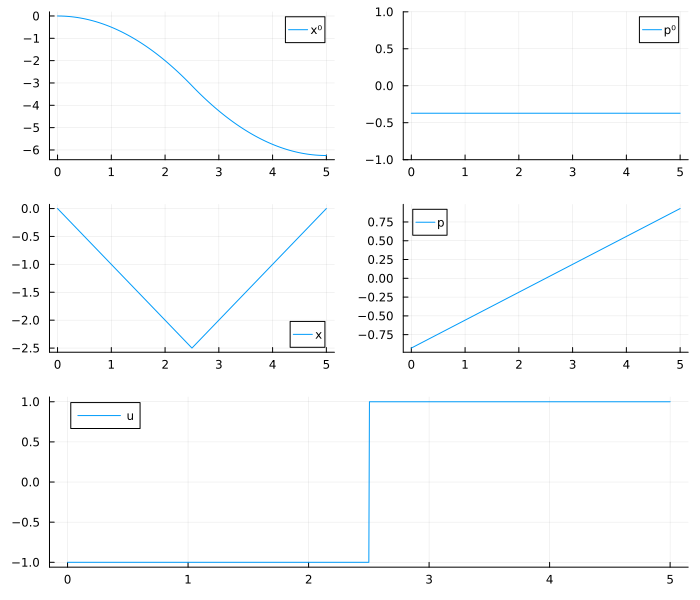

In [3]:
global iterate_S2 = Vector{Float64}()

S(p0)  = ϕₓ(p0)  - xT;                                      # general shooting function
S₁(p0) = ϕₓ₁(p0) - xT;                                      # shooting function 1 
S₂(p0) = ϕₓ₂(p0) - xT;                                      # shooting function 2

S₁!(s₁, ξ) = (s₁[:] .= S₁(ξ[1]); nothing)                   # intermediate function
function S₂!(s₂, ξ)                                         # intermediate function
    push!(iterate_S2, ξ[1])                                 # stock the iterate
    return (s₂[:] .= S₂(ξ[1]); nothing)                     
end

jS₁(ξ) = ForwardDiff.jacobian(p0 -> [S₁(p0[1])], ξ)         # compute jacobian by forward differentiation
jS₂(ξ) = ForwardDiff.jacobian(p0 -> [S₂(p0[1])], ξ)         # compute jacobian by forward differentiation
jS₁!(js₁, ξ) = (js₁[:] .= jS₁(ξ); nothing)                  # intermediate function
jS₂!(js₂, ξ) = (js₂[:] .= jS₂(ξ); nothing)                  # intermediate function

ξ = [-0.5]                                                  # initial guess
println("Evaluation on ξ : ", S₂(ξ[1]))
println("Jacobian on ξ : ", jS₂(ξ)[1])
p0_sol = fsolve(S₂!, jS₂!, ξ, show_trace = true)            # solve
println("Iterate : ", iterate_S2)
println(p0_sol)                                             # print solution
sol = ϕ((t0, tf), x0, [η(p0_sol.x[1]), p0_sol.x[1]], 
    saveat=range(t0, tf, 500))                              # get optimal trajectory

# plot
t = sol.t
x⁰ = [sol.u[i][1] for i in 1:length(sol.u)]
x  = [sol.u[i][2] for i in 1:length(sol.u)]
p⁰ = [sol.u[i][3] for i in 1:length(sol.u)]
p  = [sol.u[i][4] for i in 1:length(sol.u)]
u = sign.(p)

plt_x⁰ = plot(t, x⁰, label = "x⁰")
plt_x  = plot(t, x , label = "x" )
plt_p⁰ = plot(t, p⁰, label = "p⁰", ylim=[-1,1])
plt_p  = plot(t, p , label = "p" )
plt_u  = plot(t, u,  label = "u" )

plt_xp = plot(plt_x⁰, plt_p⁰, plt_x, plt_p, layout=(2, 2))
plot(plt_xp, plt_u, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

### Accessible set

In [4]:
function fit_ellipse(x, y)
    M = hcat(x.^2, x.*y, y.^2, x, y)            # quadratic form of ellipse
    p = M\ones(length(x))                       # fit parameters for the ellipse
    A, B, C, D, E = p
    F = -1.0
    # calculate the parameters from quadratic:
    Δ = B^2 - 4*A*C
    Λ = (A-C)^2 + B^2
    b, a = [-sqrt(clamp( 2*(A*E^2 + C*D^2 - B*D*E + Δ*F)*
            ( (A+C) + op(sqrt(Λ)) ), 0, Inf)) / Δ   for op in (+, -)]
    θ = atan(-B, C-A)/2
    c = [(2*C*D - B*E)/Δ, (2*A*E - B*D)/Δ]
    return a, b, -θ+Base.π/2, c
end

fit_ellipse (generic function with 1 method)

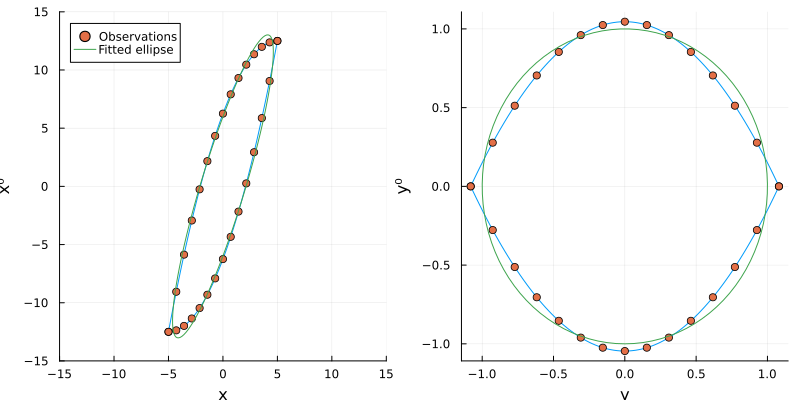

In [5]:
n = 15                                          # number of points for fit : 2n
n_ = 100                                        # number of points for plot: 2n_
p0 = [[[-1, i] for i ∈ range(-tf, 0, n)];       # initial costate for fit
      [[1, i] for i ∈ range(tf, 0, n)]]     
p0_ = [[[-1, i] for i ∈ range(-tf, 0, n_)];     # initial costate for plot
       [[1, i] for i ∈ range(tf, 0, n_)]]

x = zeros(2, 2*n); p = zeros(2,2*n)             # init final state and costate
x_ = zeros(2, 2*n_); p_ = zeros(2, 2*n_)
for i = 1:length(p0)
    x[:,i], p[:,i] = ϕ(t0, x0, p0[i], tf)       # compute flow for fit
end
for i = 1:length(p0_)
    x_[:,i], p_[:,i] = ϕ(t0, x0, p0_[i], tf)    # compute flow for plot
end

a, b, θ, c = fit_ellipse(x[1,:], x[2,:])        # fit ellipse
r(β) = [[cos(β), sin(β)] [-sin(β), cos(β)]]     # 2x2 rotation matrix
s(a,b) = [[a,0] [0,b]]                          # 2x2 scale matrix
β = range(-Base.π, Base.π; length = 100)        # angle for plot ellipse
xₑ = r(-θ)*s(a,b)*transpose(reduce(hcat,[sin.(β), cos.(β)])).+c

# construction of the linear diffeomorphism φ(x) = Ax * B
d = (a*sin(θ))/(b*cos(θ)); β₀ = atan(d)         # intermediate values
A = r(-β₀)*s(1/a,1/b)*r(θ); B = -A*c            # calculate A and B
φ(x) = A*x .+ B                                 # function φ

y = φ(x); y_ = φ(x_); yₑ = φ(xₑ)                # compute φ on x, x_ and xₑ

# plot
plt_x = plot(x_[2,:], x_[1,:], label = "")
scatter!(x[2,:], x[1,:], label="Observations", legend = :topleft)
plot!(xₑ[2,:], xₑ[1,:], label = "Fitted ellipse")
plot!(xlim = [-15,15], ylim = [-15,15], xlabel = "x", ylabel = "x⁰")

plt_y = plot(y_[2,:], y_[1,:], label = "")
scatter!(y[2,:], y[1,:], label="")
plot!(yₑ[2,:], yₑ[1,:], label = "")
plot!( xlabel = "y", ylabel = "y⁰")

plot(plt_x, plt_y, layout = (1,2), size=(800, 400))

┌ Info: Saved animation to C:\Users\uiv02757\AppData\Local\Temp\jl_AtmvCduHqT.gif
└ @ Plots C:\Users\uiv02757\.julia\packages\Plots\du2dt\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\uiv02757\\AppData\\Local\\Temp\\jl_AtmvCduHqT.gif")
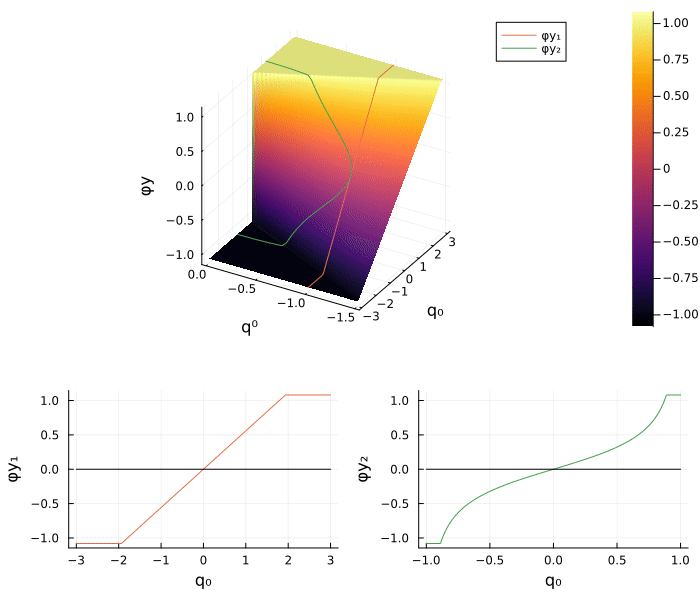

In [6]:
p₀(p) = [p[1], p[2] + p[1]*tf]
Aₓ = A[2,2]; Bₓ = B[2]
yT = Aₓ*xT + Bₓ                                     # target in the new coordinate 
ϕy(q) = Aₓ*(ϕₓ ∘ p₀)(transpose(A) *q) + Bₓ
ϕy₁(q) = ϕy([-1, q])
ϕy₂(q) = abs(q) < 1 ? ϕy([η(q), q]) : sign(q)*(Aₓ*tf + Bₓ)
# Plot
plt_S1 = plot(range(-3, 3, 500), ϕy₁ , color = 2)
plot!([-3,3], [yT,yT], color = :black)
plot!(xlabel = "q₀", ylabel = "φy₁", legend=false)

plt_S2 = plot(range(-1, 1, 500), ϕy₂, color = 3)
plot!([-1,1], [xT,xT], color = :black)
plot!(xlabel = "q₀", ylabel = "φy₂", legend=false)

ϕy_(q⁰, q) = ϕy([q⁰, q])
plt_S = surface(range(0, -1.5, 100), range(-3, 3, 100), ϕy_, camera = (30,30))
surface!(xlabel = "q⁰", ylabel = "q₀", zlabel = "φy", xflip = true)
plot3d!(-1*ones(100), range(-3, 3, 100), ϕy₁.(range(-3, 3, 100)), label = "φy₁")
plot3d!(η.(range(-1, 1, 100)), range(-1, 1, 100), ϕy₂.(range(-1, 1, 100)), label = "φy₂")

plt_S12 = plot(plt_S1, plt_S2, layout = (1,2))
plt_total = plot(plt_S, plt_S12, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

@gif for i ∈ [range(30, 90, 50); 90*ones(25); range(90, 30, 50); 30*ones(25)]
    plot!(plt_total[1], camera=(i,i), 
        zticks = i==90 ? false : true,
        zlabel = i==90 ? "" : "φy" )
end

Evaluation on ξ : 0.05611271075882162
Jacobian on ξ : 0.5667950581697939
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     5.611271e-02     0.000000e+00         0.000000
     2     5.583147e-04     9.801000e-03         0.015000
     3     2.826431e-06     9.899008e-07         0.000000
     4     1.423836e-12     2.562823e-11         0.001000
     5     6.718471e-15     6.503726e-24         0.000000
     6     4.798908e-15     1.434480e-28         0.001000
     7     7.678253e-16     2.490416e-29         0.000000
     8     9.597816e-17     4.738009e-31         0.001000
     9     9.597816e-17     5.849393e-33         0.000000
    10     4.798908e-16     5.849393e-31         0.001000
    11     9.597816e-17     7.400110e-31         0.000000
    12     4.798908e-16     1.183291e-31         0.002000
    13     9.597816e-17     4.626962e-32         0.000000
    14     9.597816e-17     7.403139e-33         0.001000
    

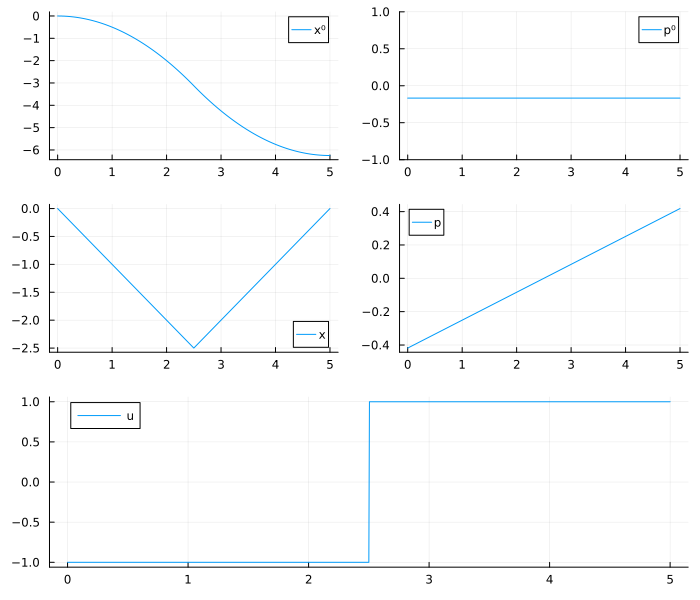

In [7]:
global iterate_T2 = Vector{Float64}()

T(q0)  = ϕy(q0)  - yT;                                      # general shooting function
T₁(q0) = ϕy₁(q0) - yT;                                      # shooting function 1 
T₂(q0) = ϕy₂(q0) - yT;                                      # shooting function 2

T₁!(t₁, ξ) = (t₁[:] .= T₁(ξ[1]); nothing)                   # intermediate function
function T₂!(t₂, ξ)                                         # intermediate function
     push!(iterate_T2, ξ[1])  
     return (t₂[:] .= T₂(ξ[1]); nothing)                   
end

jT₁(ξ) = ForwardDiff.jacobian(q0 -> [T₁(q0[1])], ξ)         # compute jacobian by forward differentiation
jT₂(ξ) = ForwardDiff.jacobian(q0 -> [T₂(q0[1])], ξ)         # compute jacobian by forward differentiation
jT₁!(jt₁, ξ) = (jt₁[:] .= jT₁(ξ); nothing)                  # intermediate function
jT₂!(jt₂, ξ) = (jt₂[:] .= jT₂(ξ); nothing)                  # intermediate function

ξ = [0.1]                                                   # initial guess
println("Evaluation on ξ : ", T₂(ξ[1]))
println("Jacobian on ξ : ", jT₂(ξ)[1])

q_sol = fsolve(T₂!, jT₂!, ξ, show_trace = true)            # solve
println("Iterate : ", iterate_T2)
println(q_sol)                                             # print solution
p0_sol = p₀(transpose(A)*[η(q_sol.x[1]), q_sol.x[1]])
sol = ϕ((t0, tf), x0, p0_sol, 
     saveat=range(t0, tf, 500))                             # get optimal trajectory

# plot
t = sol.t
x⁰ = [sol.u[i][1] for i in 1:length(sol.u)]
x  = [sol.u[i][2] for i in 1:length(sol.u)]
p⁰ = [sol.u[i][3] for i in 1:length(sol.u)]
p  = [sol.u[i][4] for i in 1:length(sol.u)]
u = sign.(p)

plt_x⁰ = plot(t, x⁰, label = "x⁰")
plt_x  = plot(t, x , label = "x" )
plt_p⁰ = plot(t, p⁰, label = "p⁰", ylim=[-1,1])
plt_p  = plot(t, p , label = "p" )
plt_u  = plot(t, u,  label = "u" )

plt_xp = plot(plt_x⁰, plt_p⁰, plt_x, plt_p, layout=(2, 2))
plot(plt_xp, plt_u, layout = grid(2,1, heights = [2/3, 1/3]), size=(700, 600))

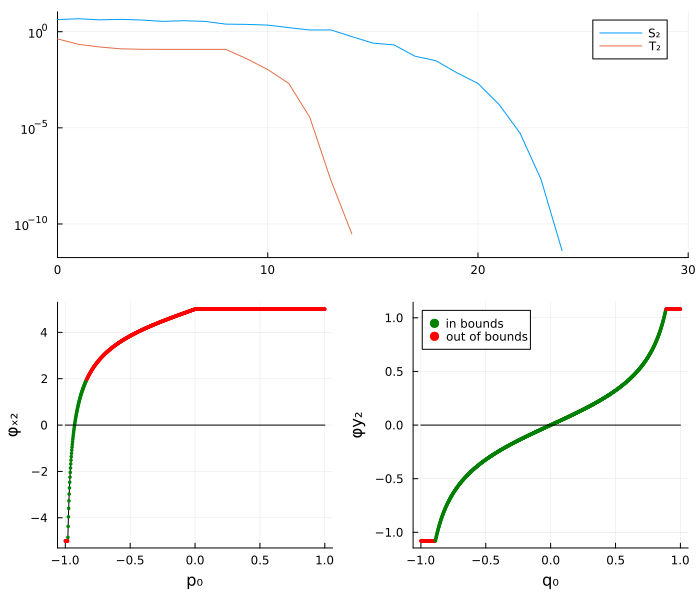

In [11]:
N = 1000
ξ = range(-1.,1.,N)
fnorms_S2 = zeros(N, 100); fnorms_T2 = zeros(N, 100)
iterates_S2 = zeros(N, 100); iterates_T2 = zeros(N, 100)
hit_bounds_S2 = zeros(N,1); hit_bounds_T2 = zeros(N,1)
for i = 1:N
    # remove old iterates
    global iterate_S2 = Vector{Float64}()
    global iterate_T2 = Vector{Float64}()
    # solve 
    q_sol_S2 = fsolve(S₂!, jS₂!, [ξ[i]], show_trace = false, tracing = true)
    q_sol_T2 = fsolve(T₂!, jT₂!, [ξ[i]], show_trace = false, tracing = true)            
    # get fnorm 
    fnorm_S2 = [q_sol_S2.trace.trace[j].fnorm for j ∈ 1:length(q_sol_S2.trace.trace)]
    fnorm_T2 = [q_sol_T2.trace.trace[j].fnorm for j ∈ 1:length(q_sol_T2.trace.trace)] 
    # get iterates
    iterates_S2[i,1:length(iterate_S2)] = iterate_S2
    iterates_T2[i,1:length(iterate_T2)] = iterate_T2
    # hit bounds
    hit_bounds_S2[i] = length(findall(x-> abs(x) > 1, iterate_S2)) != 0
    hit_bounds_T2[i] = length(findall(x-> abs(x) > 1, iterate_T2)) != 0
    # add to the array
    fnorms_S2[i,1:length(fnorm_S2)] = fnorm_S2
    fnorms_T2[i,1:length(fnorm_T2)] = fnorm_T2 
end
# mean 
mean_fnorms_S2 = mean(fnorms_S2, dims = 1)
mean_fnorms_T2 = mean(fnorms_T2, dims = 1)
# remove last 0
mean_fnorms_S2 = mean_fnorms_S2[1:findall(x -> x < 1e-10, mean_fnorms_S2)[1][2]]
mean_fnorms_T2 = mean_fnorms_T2[1:findall(x -> x < 1e-10, mean_fnorms_T2)[1][2]]
# plots
plt_1 = plot(0:length(mean_fnorms_S2)-1, mean_fnorms_S2, label = "S₂")
plot!(0:length(mean_fnorms_T2)-1, mean_fnorms_T2, label = "T₂")
plot!(yaxis = :log10, xlim = [0, 30])

plt_21 = plot(ξ, ϕₓ₂, color = :black, label = "")
color = [hit_bounds_S2[i]==1 ? :red : :green for i ∈ 1:N]
scatter!(ξ, ϕₓ₂, color = color, markerstrokecolor = color, marker = 2, label ="")
plot!([-1,1], [xT,xT], color = :black, label = "")
plot!(xlabel = "p₀", ylabel = "φₓ₂", label = "")

plt_22 = plot(ξ, ϕy₂, color = :black, label = "")
color = [hit_bounds_T2[i]==1 ? :red : :green for i ∈ 1:N]
scatter!(ξ, ϕy₂, markercolor = color, markerstrokecolor = color, marker = 2, label = "")
plot!([-1,1], [yT,yT], color = :black, label = "")
plot!(xlabel = "q₀", ylabel = "φy₂", label = "")
scatter!(1,1, markercolor = :green, markerstrokecolor = :green, marker = 2, label = "in bounds")
scatter!(1,1, markercolor = :red, markerstrokecolor = :red, marker = 2, label = "out of bounds")

plt_2 = plot(plt_21, plt_22, layout = (1,2))
plot(plt_1, plt_2, layout = grid(2,1, heights = [0.5, 0.5]), size=(700, 600))
